In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from binarypredictor.dataset import FunctionPairDataset
from binarypredictor.net import DerivativeNet, TangentNet

In [2]:
@torch.enable_grad()
def epoch(net, train_loader, loss_func, optimizer, f_func, g_func):
    """
    Training epoch of the network
    
    Parameters
    ----------
    net : TangentNet 
        neural network to train
    train_loader : DataLoader
        training data
    loss_func : torch.nn loss function
        loss function
    optimizer : torch.optim optimizer
        optimizer
    f_func : callable
        function which is evaluated with the network outputs and compared to g_func
    g_func : callable
        function which is evaluated at x and compared to f_func
        
    Returns
    -------
    float :
        mean epoch loss
    """
    
    epoch_losses = np.zeros([len(train_loader), ])
    
    for i, d in enumerate(train_loader):
        inp = torch.hstack((d[0][:, :, 0], d[0][:, :, 1]))  # network input
        out = net(inp)  # network output
        out = torch.clamp(out, min=1e-10, max=1.-1e-4)  # clamp outputs for numerical stability
        
        # Evaluate the functions for the loss (common tangent equations)
        f = f_func(out, d[1][0])/d[2].unsqueeze(-1)
        g = g_func(x, d[1][1])/d[2].unsqueeze(-1)
        
        # Calculate the loss
        loss = loss_func(f, g)
        epoch_losses[i] = loss
        
        # Backward step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return epoch_losses.mean()

In [3]:
@torch.enable_grad()
def train(net, train_loader, test_loader, f_func, g_func, nr_epochs, lr, print_every=10, net_filename='net_1.pth'):
    """
    Training of the network
    
    Parameters
    ----------
    net : TangentNet 
        neural network to train
    train_loader : DataLoader
        training data
    test_loader : DataLoader
        test data
    f_func : callable
        function which is evaluated with the network outputs and compared to g_func
    g_func : callable
        function which is evaluated at x and compared to f_func
    nr_epochs : int
        number of epochs to train
    lr : float
        learning rate
    print_every : int
        multiple of epochs where losses are printed
    net_filename : str
        filename to save to net at
        
    Returns 
    -------
    DerivativeNet :
        net with best training loss
    """
    
    loss_func = nn.L1Loss()
    optimizer = Adam(net.parameters(), lr=lr)
    
    losses = np.zeros([nr_epochs, ])
    test_losses = np.zeros([nr_epochs // print_every, ])

    best_loss = epoch(net, train_loader, loss_func, optimizer, f_func, g_func)
    best_net = net
    
    for i in range(nr_epochs):
        losses[i] = epoch(net, train_loader, loss_func, optimizer, f_func, g_func)
        if losses[i] < best_loss:
            best_net = net
            best_loss = losses[i]

        if i % print_every == 0:
            print('Train loss : ', losses[i])
            test_losses[i // print_every] = test(best_net, test_loader, f_func, g_func, loss_func)
            print('Test loss: ', test_losses[i // print_every])
            
            torch.save(best_net, net_filename)
    
    return best_net, losses, test_losses

@torch.no_grad()
def test(net, test_loader, f_func, g_func, metric): 
    """
    Training of the network
    
    Parameters
    ----------
    net : TangentNet 
        neural network to test
    test_loader : DataLoader
        test data
    f_func : callable
        function which is evaluated with the network outputs and compared to g_func
    g_func : callable
        function which is evaluated at x and compared to f_func
    metric : callable
        metric to evaluate the network with
        
    Returns 
    -------
    float :
        loss on the test set
    """
        
    test_losses = np.zeros([len(train_loader), ])

    for i, d in enumerate(test_loader):
        inp = torch.hstack((d[0][:, :, 0], d[0][:, :, 1]))  # network input
        out = net(inp)  # network output
        
        # Evaluate the functions for the loss (common tangent equations)
        f = f_func(out, d[1][0])/d[2].unsqueeze(-1)
        g = g_func(x, d[1][1])/d[2].unsqueeze(-1)
        
        # Calculate the loss
        loss = metric(f, g)
        test_losses[i] = loss
    
    return test_losses.mean()

In [4]:
@torch.no_grad()
def predict(net_1, net_2, f, g, df, dg, scale=1., plot=False, acc=4, threshold=0.3, k=15):
    """
    Predicts the equilibrium compositions of a binary system
    
    Parameters
    ----------
    net_1 : TangentNet
        network to predict equation 1
    net_2 : TangentNet 
        network to predict equation 2
    f : callable
        function for f
    g : callable
        function for g 
    df : torch.tensor
        first derivative values of f at x
    dg : torch.tensor
        first derivative values of g at x
    scale : float
        scaling factor so that the maximum function value is 1
    plot : bool
        whether to plot the results
    acc : int
        accuracy of output values (number of decimals)
    threshold : float
        threshold for the deviation from the tangent's slope and the functions' slopes
    k : int
        select topk results that meet the tangent condition in order to speed up the algorithm
    """    
    net_1.eval(), net_2.eval()
    
    # Network input
    f_, g_ = f(x)/scale, g(x)/scale
    inp = torch.hstack((f_, g_))
    
    # Network outputs
    out_1 = net_1(inp)
    out_2 = net_2(inp)
                
    # Get the equilibrium compositions by calculating the points of intersections (by approximating as the intersection
    # of the lines connecting the values of out_1 and out_2 at sign changes)
    out_diff = out_1 - out_2
    idx = torch.where(abs(out_diff) < 0.1)[0][:-1]
    
    if len(idx) == 0:
        return torch.tensor([]), torch.tensor([])
    
    x_f = torch.hstack((out_1[idx], out_2[idx], out_1[idx + 1], out_2[idx + 1], 
                        (out_1[idx] + out_2[idx])/2, (out_1[idx + 1] + out_2[idx + 1])/2))
    x_g = torch.hstack((x[idx], x[idx], x[idx + 1], x[idx + 1], x[idx], x[idx + 1]))
    
    # Get the function values at the equilibria
    y_f, y_g = f(x_f)/scale, g(x_g)/scale
            
    # Get the slopes of the lines between the equilibria points
    slopes = (y_g - y_f)/(x_g - x_f)
        
    # Remove lines that are not tangents
    slope_cond = (abs(slopes - dg(x_g)/scale) <= threshold) & (abs(slopes - df(x_f)/scale) <= threshold)
    idx = torch.where(slope_cond)[0]
    
    # Recalculate x and y values for all points that are tangent points
    x_f, x_g = x_f[idx], x_g[idx]    
    slope_dist = torch.sqrt((slopes[idx] - dg(x_g)/scale) ** 2 + (slopes[idx] - df(x_f)/scale) ** 2)
    
    # Only take the k best tangents to save time
    idx = torch.topk(slope_dist, min(k, len(slope_dist)), largest=False)[1]
    x_f, x_g = x_f[idx], x_g[idx]    
    y_f, y_g = f(x_f)/scale, g(x_g)/scale
    slope_dist = torch.sqrt((slopes[idx] - dg(x_g)/scale) ** 2 + (slopes[idx] - df(x_f)/scale) ** 2)
    
    # Choose the best tangent if there are multiple results for the same tangent
    if len(x_f) > 0:
        x_eqs = torch.tensor(list(zip(x_f, x_g)))
        s_idx = torch.where(abs(torch.cdist(x_eqs, x_eqs)) < 0.05)
        
        left, right = s_idx[0], s_idx[1]
        left_unique = torch.unique(left)
        
        cis = []
        for i in left_unique:
            idx = torch.where(left == i)[0]
            add = right[idx]
            if len(add) > 0:
                cis.append(torch.argmin(slope_dist[add])) 
            else:
                continue
            right = torch.tensor([r for r in right if r not in add])
            left = torch.tensor([l for l in left if l not in add]) 
            
        cis = torch.tensor(cis)
            
        x_f, x_g = torch.unique(x_f[cis]), torch.unique(x_g[cis])
        y_f, y_g = f(x_f)/scale, g(x_g)/scale
    
    # Plot the outputs
    if plot:
        plt.scatter(x, out_1.detach(), s=0.2)
        plt.scatter(x, out_2.detach(), s=0.2)
        plt.title('Network outputs')
        plt.xlabel('x\'\'')
        plt.ylabel('x\'')
        plt.grid()
        plt.show()

        plt.scatter(x, out_diff.detach(), s=0.2)
        plt.title('Difference between network outputs')
        plt.xlabel('x\'\'')
        plt.ylabel('Difference')
        plt.grid()
        plt.show()
        
        print('x\'_eq: ', np.round(x_f.tolist(), decimals=acc))
        print('x\'\'_eq: ', np.round(x_g.tolist(), decimals=acc))
        
        for x_f_eq, x_g_eq, y_f_eq, y_g_eq in zip(x_f, x_g, y_f, y_g):
            plt.plot([x_f_eq, x_g_eq], [y_f_eq, y_g_eq], 'ro-')
            plt.plot(x, f_)
            plt.plot(x, g_)
            plt.show()
            
    return x_f, x_g

In [5]:
out_features = 500
in_features = out_features

In [38]:
#fpd = FunctionPairDataset(n_functions=250000, filename="train_1m.csv", overwrite=True, step=1/in_features)
#fpd.create_functions()

fpd_test = FunctionPairDataset(n_functions=100000, filename="ae_train.csv", overwrite=True, step=1/in_features)
fpd_test.create_functions()

loader = DataLoader(fpd_test, batch_size=1028, shuffle=True)

In [39]:
x = torch.arange(1e-10, 1., step=fpd_test.step)

In [40]:
class AutoEncoder(nn.Module):
    """ Fully connected auto-encoder. """
    
    def __init__(self, in_features: int, hidden_features: int, code_features: int, 
                 activation: nn.Module = nn.ReLU()):
        """
        Parameters
        ----------
        in_features : int
            Dimensionality of the inputs.
        code_features : int
            Dimensionality of the code.
        activation : nn.Module
            Activation function to use for the codes.
        """
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            activation,
            nn.Linear(hidden_features, hidden_features),
            activation,
            nn.Linear(hidden_features, code_features),
            activation
        )

        self.decoder = nn.Sequential(
            nn.Linear(code_features, hidden_features),
            activation,
            nn.Linear(hidden_features, hidden_features),
            activation,
            nn.Linear(hidden_features, in_features),
        )
        
    def forward(self, x):
        x = self.encoder(x)  # Encode
        x = self.decoder(x)  # Decode

        return x

In [41]:
ae = AutoEncoder(1000, 500, 100)

# Loss function
loss_fn = nn.MSELoss()

lr = 1e-3
# Optimizer
optimizer = Adam(ae.parameters(), lr=lr)

for i in range(1000):
    for d in loader:
        inp = torch.hstack((d[0][0][:, 0], d[0][0][:, 1])).unsqueeze(0)
        out = ae(inp)

        loss = loss_fn(out, inp)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

KeyboardInterrupt: 

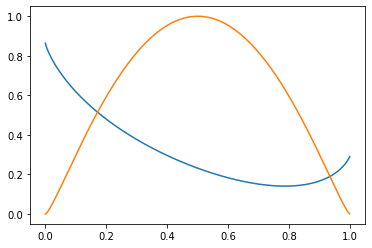

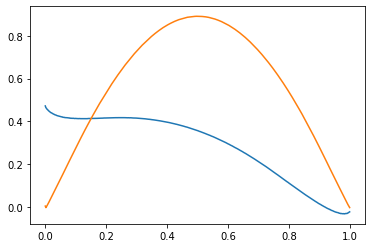

In [54]:
idx = 8

inp = torch.hstack((fpd_test[idx][0][:, 0], fpd_test[idx][0][:, 1])).unsqueeze(0)
out = ae(inp)

plt.plot(x, fpd_test[idx][0][:, 0])
plt.plot(x, fpd_test[idx][0][:, 1])
plt.show()

out_ = out.squeeze().detach()

plt.plot(x, out_[:500])
plt.plot(x, out_[500:])
plt.show()

In [45]:
#torch.save(ae, 'ae.pth')